#Predict Delivery

# Contents
1- Data Cleaning

2- Feature Selection

3- XGB

4- DNN

5- Predict

In [1]:
#Import packages&read data
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from pytz import timezone
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [91]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [92]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [93]:
data = pd.read_csv('historical_data.csv')


In [ ]:
predict = pd.read_csv('predict_data.csv')

In [5]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

In [7]:
data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [8]:
data.isnull().sum().sort_values(ascending=False)

total_outstanding_orders                        16262
total_busy_dashers                              16262
total_onshift_dashers                           16262
store_primary_category                           4760
order_protocol                                    995
market_id                                         987
estimated_store_to_consumer_driving_duration      526
actual_delivery_time                                7
estimated_order_place_duration                      0
max_item_price                                      0
min_item_price                                      0
num_distinct_items                                  0
subtotal                                            0
total_items                                         0
store_id                                            0
created_at                                          0
dtype: int64

# 1-Data Cleaning

1.1 Calculate delivery time, add features about time

In [94]:
#Transfer roginal time to date time to calculate length of delivery time
data['A']=pd.to_datetime(data['created_at'])
data['B']=pd.to_datetime(data['actual_delivery_time'])
data['length'] = (data['B']-data['A']).dt.seconds

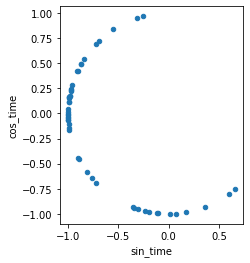

In [95]:
#Transfer time zone of create order time, create sin_time +cons_time variable that could shows the cycling characteristics of time
#Assume that the length of delivery should be correlated with the time of order created (for example, dinner takes longer than lunch)
data['C'] =  data['A'].dt.tz_localize("UTC")
data['D'] =  data['C'].dt.tz_convert('US/Pacific')
data['hour']= data['D'].dt.hour
data['minute']= data['D'].dt.minute
data['hourfloat']=data.hour+data.minute/60.0
data['sin_time']=np.sin(2.*np.pi*data.hourfloat/24.)
data['cos_time']=np.cos(2.*np.pi*data.hourfloat/24.)
data.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

In [96]:
#Create weekday, month and year of order generated
#Assume that length of delivery should be correlated with the day/month/year of order created (for example,length(Saturday)>length(Monday))
data['weekday'] = data['D'].dt.day_name()
data['month']= data['D'].dt.month
data['year']= data['D'].dt.year

1.2 Outliers

In [97]:
#show distribution of all numerical variables
data[['market_id', 'store_id','order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_busy_dashers', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration','length','month', 'year']].describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,length,month,year
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,197421.000000,197428.000000,197428.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,2862.304816,1.627920,2014.999995
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,1180.916229,0.483738,0.002251
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000,1.000000,2014.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2104.000000,1.000000,2015.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2660.000000,2.000000,2015.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3381.000000,2.000000,2015.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,73282.000000,10.000000,2015.000000


In [98]:
data.nlargest(10, 'total_items')

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,A,B,length,C,D,hour,minute,hourfloat,sin_time,cos_time,weekday,month,year
47231,2.0,2015-02-06 00:42:39,2015-02-06 01:33:34,777,fast,4.0,411,3115,5,0,299,35.0,35.0,39.0,251,573.0,2015-02-06 00:42:39,2015-02-06 01:33:34,3055.0,2015-02-06 00:42:39+00:00,2015-02-05 16:42:39-08:00,16,42,16.700000,-0.942641,-0.333807,Thursday,2,2015
182223,6.0,2015-02-15 19:39:32,2015-02-15 20:54:10,1862,fast,4.0,84,1016,4,0,289,NaN,NaN,NaN,251,581.0,2015-02-15 19:39:32,2015-02-15 20:54:10,4478.0,2015-02-15 19:39:32+00:00,2015-02-15 11:39:32-08:00,11,39,11.650000,0.091502,-0.995805,Sunday,2,2015
182800,2.0,2015-02-18 05:42:03,2015-02-18 06:11:25,6931,fast,4.0,66,1634,6,0,499,30.0,28.0,32.0,251,389.0,2015-02-18 05:42:03,2015-02-18 06:11:25,1762.0,2015-02-18 05:42:03+00:00,2015-02-17 21:42:03-08:00,21,42,21.700000,-0.566406,0.824126,Tuesday,2,2015
182796,2.0,2015-02-17 05:45:05,2015-02-17 06:14:01,6931,fast,4.0,64,1166,4,0,499,28.0,19.0,21.0,251,389.0,2015-02-17 05:45:05,2015-02-17 06:14:01,1736.0,2015-02-17 05:45:05+00:00,2015-02-16 21:45:05-08:00,21,45,21.750000,-0.555570,0.831470,Monday,2,2015
75577,1.0,2015-01-23 04:33:00,2015-01-23 05:07:45,933,fast,4.0,59,2911,3,0,329,25.0,19.0,20.0,251,470.0,2015-01-23 04:33:00,2015-01-23 05:07:45,2085.0,2015-01-23 04:33:00+00:00,2015-01-22 20:33:00-08:00,20,33,20.550000,-0.785317,0.619094,Thursday,1,2015
15053,4.0,2015-01-26 22:48:56,2015-01-26 23:28:02,6628,fast,4.0,57,858,5,0,229,25.0,54.0,19.0,251,420.0,2015-01-26 22:48:56,2015-01-26 23:28:02,2346.0,2015-01-26 22:48:56+00:00,2015-01-26 14:48:56-08:00,14,48,14.800000,-0.669131,-0.743145,Monday,1,2015
11055,2.0,2015-01-22 01:07:03,2015-01-22 01:55:43,4189,fast,4.0,56,2317,7,0,289,35.0,27.0,26.0,251,579.0,2015-01-22 01:07:03,2015-01-22 01:55:43,2920.0,2015-01-22 01:07:03+00:00,2015-01-21 17:07:03-08:00,17,7,17.116667,-0.973379,-0.229200,Wednesday,1,2015
105348,3.0,2015-01-23 15:46:35,2015-01-23 16:56:32,5348,fast,4.0,51,1343,4,0,169,3.0,1.0,2.0,251,628.0,2015-01-23 15:46:35,2015-01-23 16:56:32,4197.0,2015-01-23 15:46:35+00:00,2015-01-23 07:46:35-08:00,7,46,7.766667,0.894934,-0.446198,Friday,1,2015
52211,6.0,2015-02-09 03:24:52,2015-02-09 04:29:24,3242,fast,4.0,50,2133,10,0,309,NaN,NaN,NaN,251,644.0,2015-02-09 03:24:52,2015-02-09 04:29:24,3872.0,2015-02-09 03:24:52+00:00,2015-02-08 19:24:52-08:00,19,24,19.400000,-0.933580,0.358368,Sunday,2,2015
106098,5.0,2015-01-23 03:21:39,2015-01-23 04:30:58,6047,NaN,4.0,50,2250,8,0,360,22.0,11.0,16.0,251,439.0,2015-01-23 03:21:39,2015-01-23 04:30:58,4159.0,2015-01-23 03:21:39+00:00,2015-01-22 19:21:39-08:00,19,21,19.350000,-0.938191,0.346117,Thursday,1,2015


In [99]:
#Variables with extrem outliers: total_items, subtotal, min_item_price, max_item_price, estimated_order_place_duration, length
#total_items -> remove orders with too many (411) total items

data.drop(data[data['total_items'] >= 411].index, inplace = True) 

In [100]:
#min_item_price, max_item_price
#remove: min_item_price <0, min_item_price >= 14700
data.drop(data[data['min_item_price'] >= 14700].index, inplace = True) 
data.drop(data[data['min_item_price'] < 0].index, inplace = True) 

In [101]:
#length of delivery
#find there are several orders were delivered after one day: assume they are like reservations instead of ASAP delivery
data['lengthday'] = (data['B']-data['A']).dt.days
data['lengthtest'] = data['B']-data['A']
data['lengthday'].describe()
data['lengthtest'].describe()
data.drop(data[data['lengthday'] >= 1].index, inplace = True) 

(array([1., 0., 1., ..., 0., 0., 1.]),
 array([  101.       ,   144.8605547,   188.7211094, ..., 56944.2788906,
        56988.1394453, 57032.       ]),
 <a list of 1298 Patch objects>)

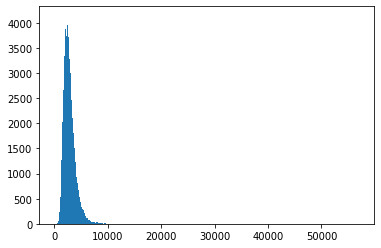

In [102]:
plt.hist(data['length'], bins='auto')

In [103]:
data['length'].quantile([0,.01,.05,.1,0.95,0.98, 0.99,1])

0.00      101.00
0.01     1152.00
0.05     1492.00
0.10     1699.00
0.95     4872.00
0.98     5737.00
0.99     6472.98
1.00    57032.00
Name: length, dtype: float64

In [104]:
#Remove orders that deliveried after more than 3 hours (10800 seconds) created, based on the distribution,and logic
#it is unlikely that an ASAP order is delivered after 3 hours
data.drop(data[data['length'] >= 10800].index, inplace = True) 

In [106]:
data[['market_id', 'store_id','order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_busy_dashers', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration','length','month', 'year']].describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,length,month,year
count,197275.000000,197275.000000,197275.000000,197275.000000,197275.00000,197275.000000,197275.000000,197275.000000,181028.000000,181028.000000,181028.000000,197275.000000,196749.000000,197268.000000,197275.000000,197275.0
mean,2.963908,3530.634794,2.867697,3.193679,2682.24217,2.670713,686.137012,1159.514160,44.816575,41.747597,58.059836,308.556386,545.309857,2852.007888,1.627819,2015.0
std,1.535388,2053.522089,1.513793,2.500972,1822.87902,1.630159,520.818465,557.358907,34.526807,32.145528,52.663538,90.138894,219.342466,1082.474391,0.483388,0.0
min,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000,1.000000,2015.0
25%,2.000000,1686.000000,1.000000,2.000000,1400.00000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2104.000000,1.000000,2015.0
50%,3.000000,3592.000000,3.000000,3.000000,2200.00000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2659.000000,2.000000,2015.0
75%,4.000000,5299.000000,4.000000,4.000000,3395.00000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3379.000000,2.000000,2015.0
max,6.000000,6987.000000,7.000000,84.000000,27100.00000,20.000000,8999.000000,8999.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,10791.000000,2.000000,2015.0


1.3 Missing data

In [107]:
#check null distribution
data.isnull().sum().sort_values(ascending=False)

total_onshift_dashers                           16247
total_busy_dashers                              16247
total_outstanding_orders                        16247
estimated_store_to_consumer_driving_duration      526
length                                              7
actual_delivery_time                                7
lengthday                                           7
B                                                   7
lengthtest                                          7
hour                                                0
D                                                   0
created_at                                          0
year                                                0
store_id                                            0
store_primary_category                              0
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items          

In [105]:
#for City and order protocol, for missing value, create new category as 0
#for restaurant with missing category, fill as missing
data['market_id'].fillna(0, inplace = True)
data['order_protocol'].fillna(0, inplace = True)
data['store_primary_category'].fillna("Missing", inplace = True)

In [108]:
#for City and order protocol, for missing value, create new category as 0
#for restaurant with missing category, fill as missing
data['market_id'].fillna(0, inplace = True)
data['order_protocol'].fillna(0, inplace = True)
data['store_primary_category'].fillna("Missing", inplace = True)

In [109]:
#For total_onshift_dashers,total_outstanding_orders,total_busy_dashers, check missing distribution among markets
#find that the dasher number are related to market and order created time(hour)
data[['total_onshift_dashers','total_outstanding_orders','total_busy_dashers','store_primary_category','market_id']].set_index('market_id').isna().sum(level=0)

,total_onshift_dashers,total_outstanding_orders,total_busy_dashers,store_primary_category
market_id,,,,
1.0,201,201,201,0
2.0,270,270,270,0
3.0,1620,1620,1620,0
4.0,215,215,215,0
0.0,68,68,68,0
5.0,92,92,92,0
6.0,13781,13781,13781,0


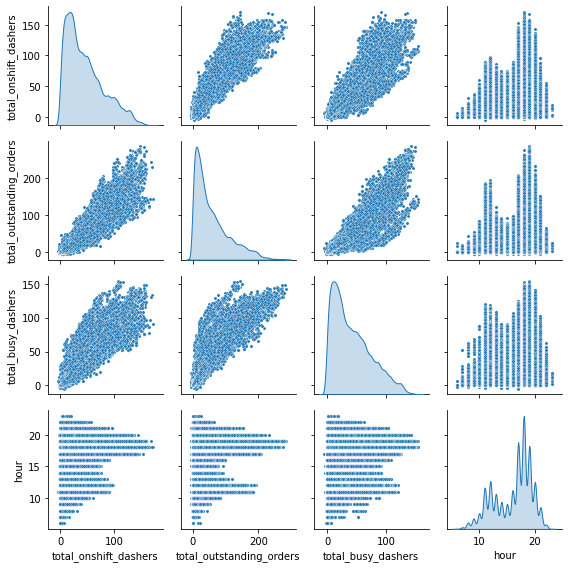

In [26]:
sns.pairplot(data, vars=['total_onshift_dashers','total_outstanding_orders','total_busy_dashers','hour'],palette = "seismic",size=2,diag_kind = "kde",diag_kws=dict(shade=True),plot_kws=dict(s=10) )

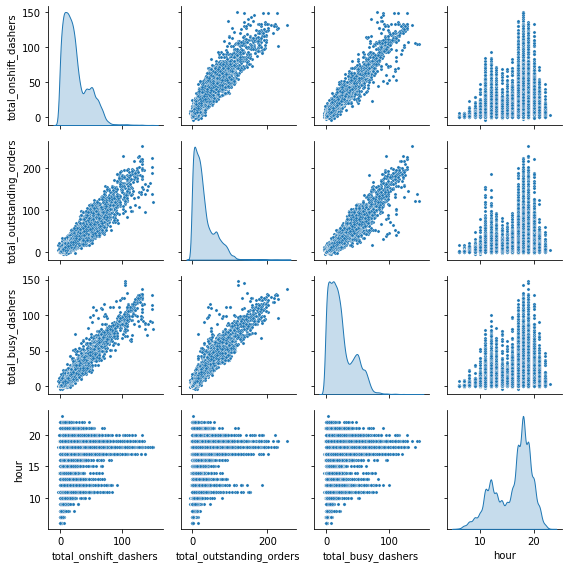

In [27]:
sns.pairplot(data.loc[data['market_id']==1], vars=['total_onshift_dashers','total_outstanding_orders','total_busy_dashers','hour'],palette = "seismic",size=2,diag_kind = "kde",diag_kws=dict(shade=True),plot_kws=dict(s=10) )

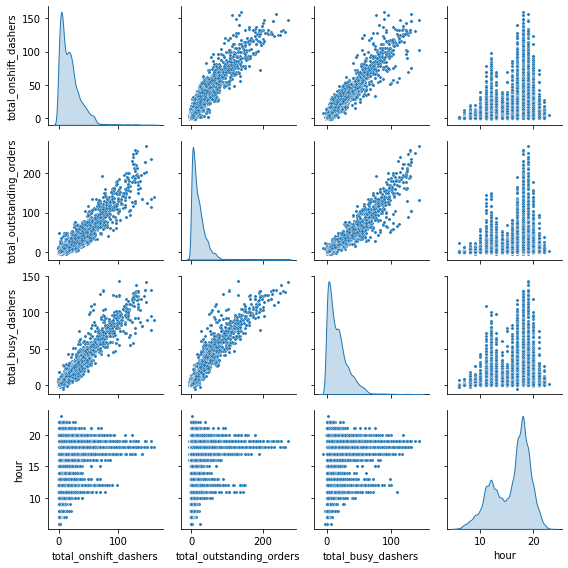

In [28]:
sns.pairplot(data.loc[data['market_id']==3], vars=['total_onshift_dashers','total_outstanding_orders','total_busy_dashers','hour'],palette = "seismic",size=2,diag_kind = "kde",diag_kws=dict(shade=True),plot_kws=dict(s=10) )

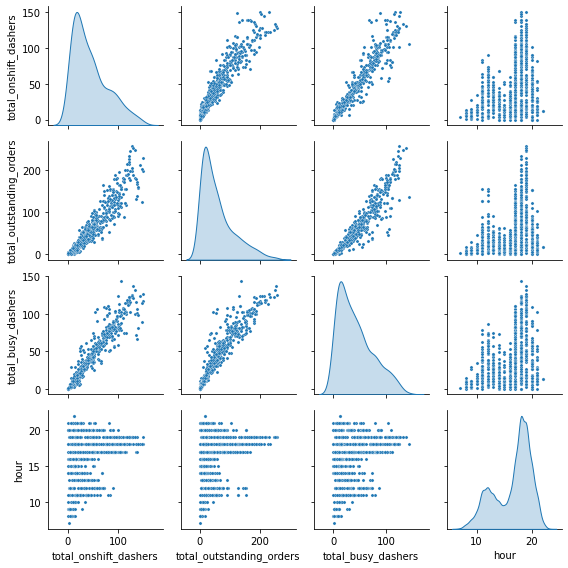

In [29]:
sns.pairplot(data.loc[data['market_id']==6], vars=['total_onshift_dashers','total_outstanding_orders','total_busy_dashers','hour'],palette = "seismic",size=2,diag_kind = "kde",diag_kws=dict(shade=True),plot_kws=dict(s=10) )

In [110]:
#fill missing dasher number based on the group mean of market and order created hour
data['total_onshift_dashers'] = data.groupby(['market_id', 'hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
data['total_outstanding_orders'] = data.groupby(['market_id', 'hour'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))
data['total_busy_dashers'] = data.groupby(['market_id', 'hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))

In [111]:
#Onshift dasher should be larger than or equals to busy dasher
len(data[data['total_busy_dashers']>data['total_onshift_dashers']])

42998

In [112]:
# Correcting for number of onshift dashers < busy dashers 
data['total_onshift_dashers'] = np.where(data['total_busy_dashers']>data['total_onshift_dashers'],
                                             data['total_busy_dashers'],data['total_onshift_dashers'])

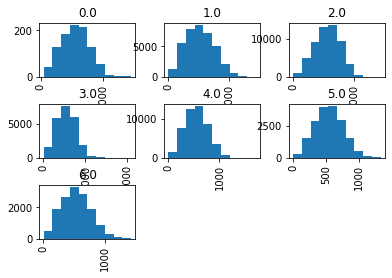

In [113]:
#deal with missing estimated_store_to_consumer_driving_duration 
#see the distribution of estimated_store_to_consumer_driving_duration among market
data['estimated_store_to_consumer_driving_duration'].hist(by=data['market_id'])
#fill missing estimate time based on the group mean of market and order created hour
data['estimated_store_to_consumer_driving_duration'] = data.groupby(['market_id', 'hour'])['estimated_store_to_consumer_driving_duration'].transform(lambda x: x.fillna(x.mean()))

In [114]:
#Missing delivery time, since the delivery time is what we want to predict, I drop the orders with missing delivery time
data = data.dropna(subset=['actual_delivery_time', 'total_outstanding_orders'])

In [115]:
data.isnull().sum().sort_values(ascending=False)

lengthtest                                      0
estimated_order_place_duration                  0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
lengthday                                       0
A                                               0
B                                               0
length                                          0


# 2-Features Selection

In [116]:
#Store primary category -> store_primary_category_updated
#check the distribution of restaurant category
res = data['store_primary_category'].value_counts(normalize=True).to_frame('percent').rename_axis('cuisin').reset_index()
print(res)

               cuisin   percent
0            american  0.098258
1               pizza  0.087734
2             mexican  0.086624
3              burger  0.055519
4            sandwich  0.050957
5             chinese  0.047727
6            japanese  0.046572
7             dessert  0.044422
8                fast  0.037285
9              indian  0.037051
10               thai  0.036590
11            italian  0.036332
12         vietnamese  0.030872
13      mediterranean  0.027932
14          breakfast  0.027460
15            Missing  0.024125
16              other  0.020211
17              salad  0.018979
18              greek  0.016845
19            seafood  0.013839
20           barbecue  0.013799
21              asian  0.012400
22               cafe  0.011279
23              sushi  0.011081
24            alcohol  0.009373
25             korean  0.009191
26           smoothie  0.008405
27           catering  0.008268
28           hawaiian  0.007594
29     middle-eastern  0.007594
30      

In [117]:
# update restaurant category, low frenquency category -> other category
# set up the threshold percent as 0.5%
threshold_percent = 0.5
series = pd.value_counts(data['store_primary_category'])
mask = (series / series.sum() * 100).lt(threshold_percent)
data = data.assign(store_primary_category_updated = np.where(data['store_primary_category'].isin(series[mask].index),'Other', data['store_primary_category']))

In [118]:
#calculate available dasher number when the order generated
data['ava_dasher']=data['total_onshift_dashers']-data['total_busy_dashers']

In [119]:
data['ava_dasher'].describe()

count    197266.000000
mean          4.696245
std           8.385186
min           0.000000
25%           0.000000
50%           1.047619
75%           6.000000
max          86.000000
Name: ava_dasher, dtype: float64

In [120]:
#check the pearson correlation of numerical features
visual = data[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price','total_onshift_dashers', 'ava_dasher', 'total_outstanding_orders', 'estimated_order_place_duration',   'estimated_store_to_consumer_driving_duration', 'hour','length']]

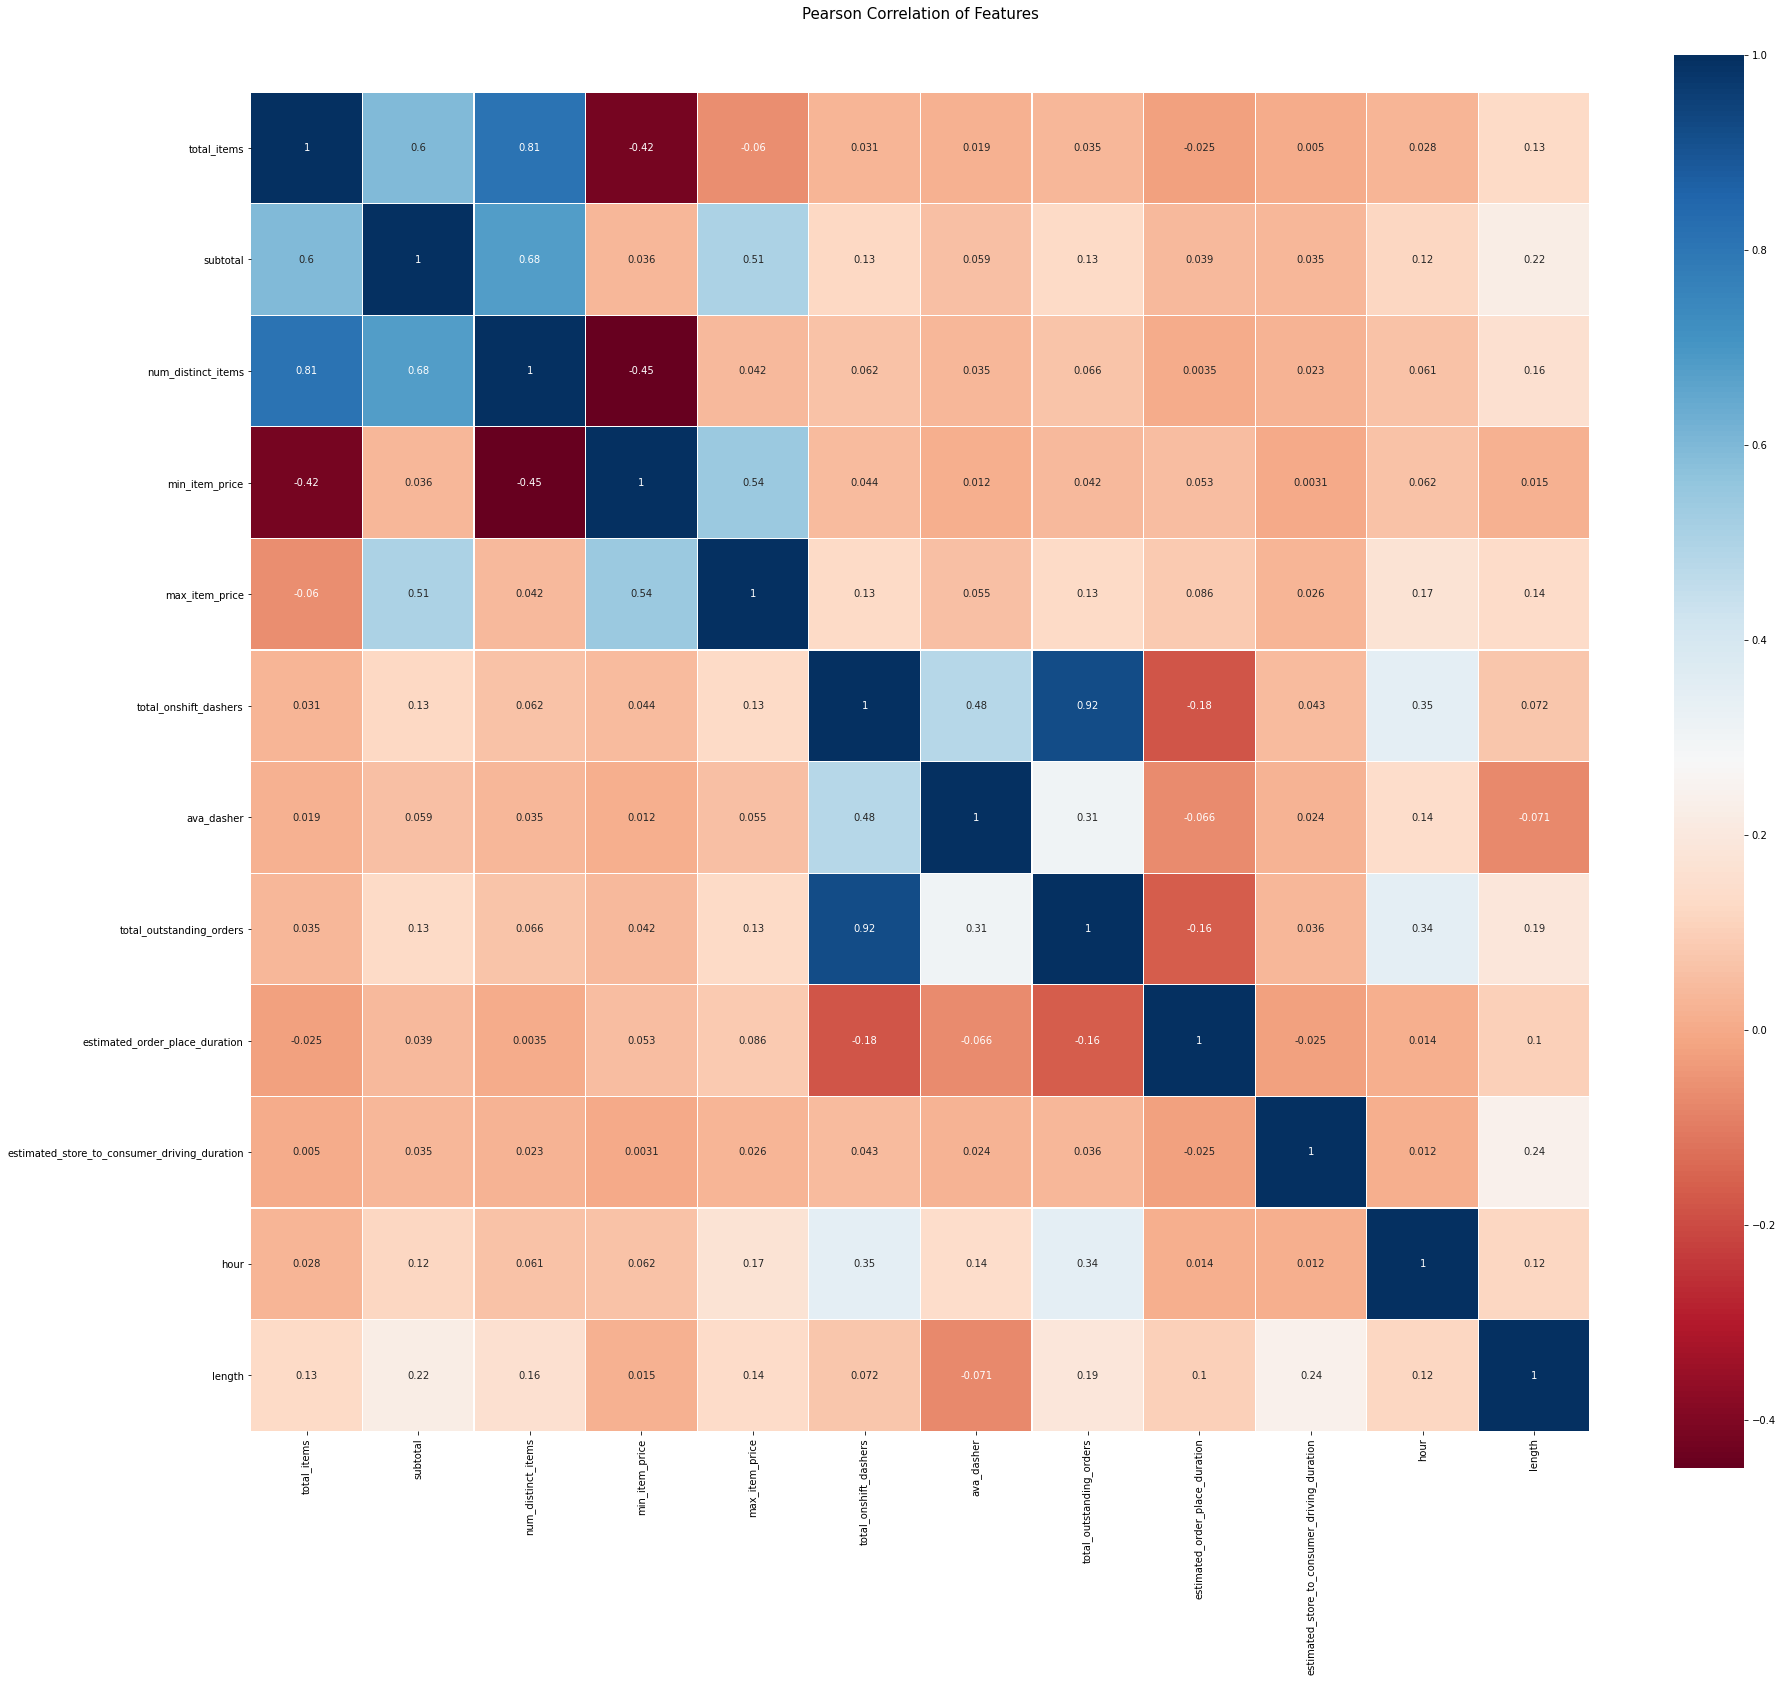

In [42]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30,26))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(visual.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [121]:
data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'A', 'B', 'length', 'C',
       'D', 'hour', 'minute', 'hourfloat', 'sin_time', 'cos_time', 'weekday',
       'month', 'year', 'lengthday', 'lengthtest',
       'store_primary_category_updated', 'ava_dasher'],
      dtype='object')

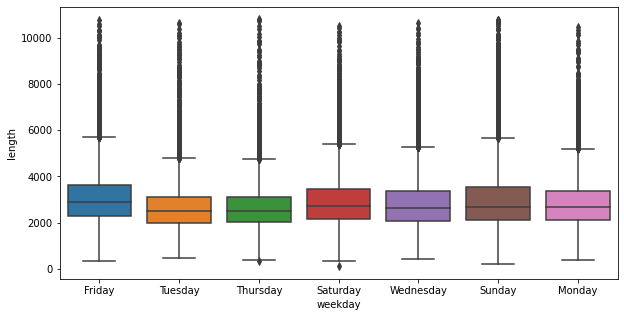

In [53]:
#check the distribution of length among categorical features
plt.figure(figsize=(10,5))
sns.boxplot(y=data['length'], x=data['weekday'])

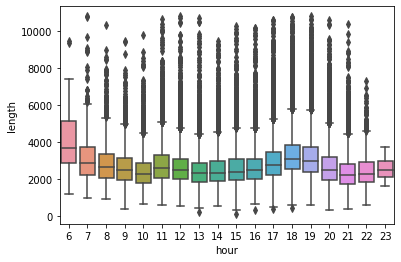

In [45]:
sns.boxplot(y=data['length'], x = data['hour'])

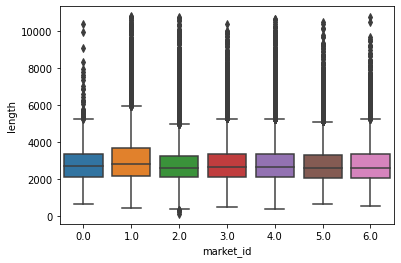

In [54]:
sns.boxplot(y=data['length'], x = data['market_id'])

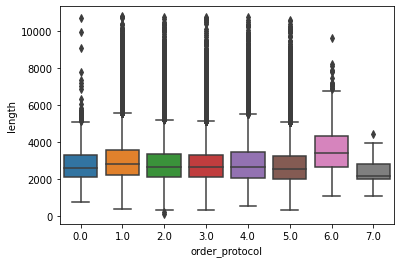

In [55]:
sns.boxplot(y=data['length'], x = data['order_protocol'])

In [122]:
#label encoding on store category,although market id, and order_protocol are numerical variables, they are not ordinal so it is better to make it one-hot encoding

from sklearn import preprocessing
labeldncode = preprocessing.LabelEncoder()
labeldncode.fit(data['store_primary_category'])
data['store_primary_category_new'] = labeldncode.transform(data['store_primary_category']) 


In [123]:
data = pd.get_dummies(data, columns=['market_id','weekday','order_protocol'], drop_first=True)

In [124]:
data.columns

Index(['created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'A', 'B', 'length', 'C',
       'D', 'hour', 'minute', 'hourfloat', 'sin_time', 'cos_time', 'month',
       'year', 'lengthday', 'lengthtest', 'store_primary_category_updated',
       'ava_dasher', 'store_primary_category_new', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'order_protocol_1.0', 'order_protocol_2.0', 'order_protocol_3.0',
       'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0',
       'order_protocol_7.0'

3- Baseline Model: XGB Boosting

In [125]:
X = data.drop(['length','created_at','actual_delivery_time','store_primary_category','store_primary_category_updated','total_busy_dashers','A', 'B','C','hour', 'minute', 'hourfloat',
       'D','month','year', 'lengthday','lengthtest'], axis=1)
y = data['length']

In [126]:
X.columns

Index(['store_id', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'sin_time', 'cos_time',
       'ava_dasher', 'store_primary_category_new', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'order_protocol_1.0', 'order_protocol_2.0', 'order_protocol_3.0',
       'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0',
       'order_protocol_7.0'],
      dtype='object')

In [127]:
X.dtypes

store_id                                          int64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
sin_time                                        float64
cos_time                                        float64
ava_dasher                                      float64
store_primary_category_new                        int64
market_id_1.0                                     uint8
market_id_2.0                                     uint8
market_id_3.0                                     uint8
market_id_4.0                                   

In [128]:
x_tr, x_te, y_tr, y_te=train_test_split(X, y, test_size=0.3, random_state=4)

In [72]:
#grid search parameter
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_tr,y_tr)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed: 14.7min finished


0.36602999989724366
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [129]:
xgbr = XGBRegressor(colsample_bytree=0.7, learning_rate=0.05,max_depth=7,min_child_weight= 4,n_estimators=500,nthread=4,objective='reg:linear',silent= 1,subsample= 0.7) 
xgbr.fit(x_tr,y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [130]:
y_tr_pred = xgbr.predict(x_tr)

In [131]:
y_te_pred = xgbr.predict(x_te)

In [132]:
mean_absolute_error(y_tr_pred, y_tr)

565.0561821492528

In [133]:
mean_absolute_error(y_te_pred, y_te)

625.1748752894374

In [79]:
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'XGB Feature Importance')

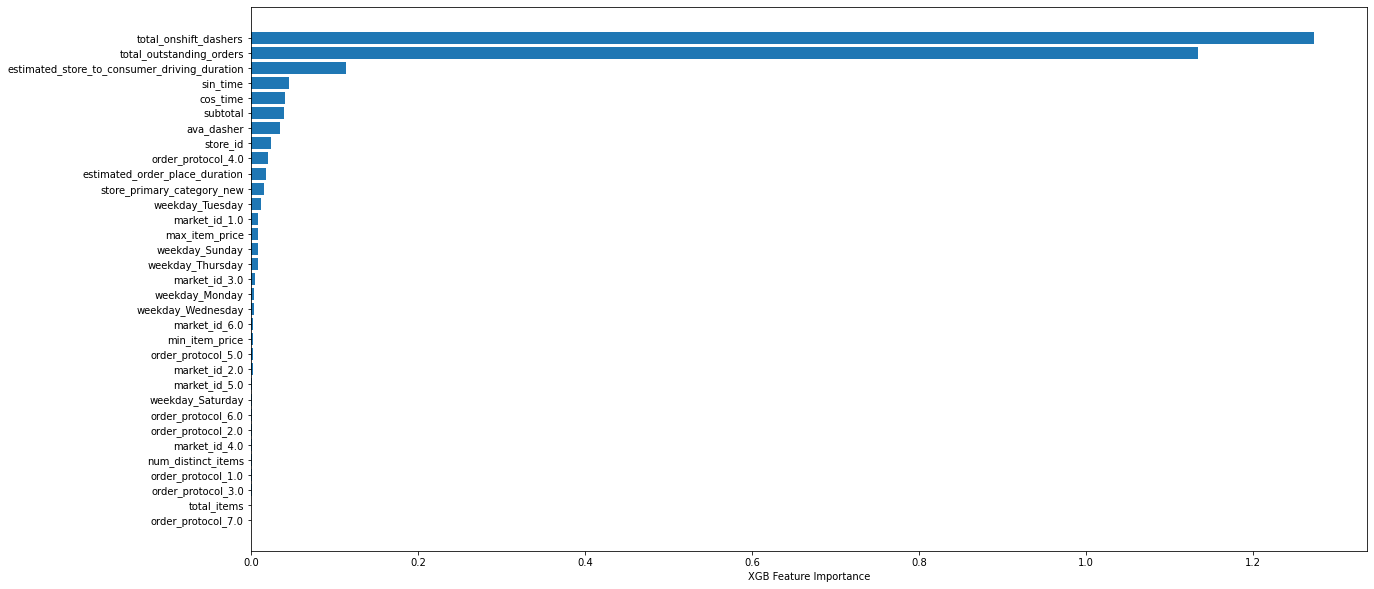

In [138]:
result = permutation_importance(xgbr, x_te, y_te, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(20,10))
plt.barh(x_te.columns[sorted_idx], result.importances_mean[sorted_idx].T)
plt.xlabel("XGB Feature Importance")

4- Deep Neural Network

In [134]:
NN_model = Sequential()
NN_model.add(Dense(58, kernel_initializer='normal',input_dim = x_tr.shape[1], activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [135]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 58)                1972      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               15104     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 148,917
Trainable params: 148,917
Non-trainable params: 0
_________________________________________________________________


In [136]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [137]:
history = NN_model.fit(x_tr, y_tr, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
3450/3453 [============================>.] - ETA: 0s - loss: 753.4835 - mean_absolute_error: 753.4835
Epoch 00001: val_loss improved from inf to 715.63190, saving model to Weights-001--715.63190.hdf5
3453/3453 [==============================] - 10s 3ms/step - loss: 753.4742 - mean_absolute_error: 753.4742 - val_loss: 715.6319 - val_mean_absolute_error: 715.6319
Epoch 2/500
3448/3453 [============================>.] - ETA: 0s - loss: 722.1029 - mean_absolute_error: 722.1029
Epoch 00002: val_loss did not improve from 715.63190
3453/3453 [==============================] - 10s 3ms/step - loss: 721.9250 - mean_absolute_error: 721.9250 - val_loss: 727.5131 - val_mean_absolute_error: 727.5131
Epoch 3/500
3432/3453 [============================>.] - ETA: 0s - loss: 710.1210 - mean_absolute_error: 710.1210
Epoch 00003: val_loss did not improve from 715.63190
3453/3453 [==============================] - 9s 3ms/step - loss: 710.0097 - mean_absolute_error: 710.0097 - val_loss: 885.6846

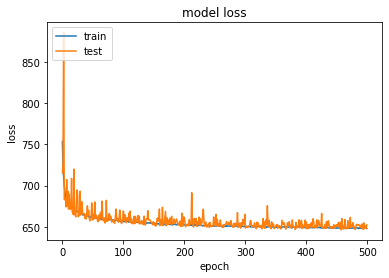

In [139]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
wights_file = 'Weights-383--646.83936.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [143]:
y_te_pre = NN_model.predict(x_te)
y_tr_pre = NN_model.predict(x_tr)

In [142]:
mean_absolute_error(y_te_pre, y_te)

651.9995008442199

In [144]:
mean_absolute_error(y_tr_pre, y_tr)

644.7741223290748

Predict data

In [145]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [146]:
predict = pd.read_csv('predict_data.csv')

In [148]:
predict['A']=pd.to_datetime(predict['created_at'])
predict['C'] =  predict['A'].dt.tz_localize("UTC")
predict['D'] =  predict['C'].dt.tz_convert('US/Pacific')
predict['hour']= predict['D'].dt.hour
predict['minute']= predict['D'].dt.minute
predict['hourfloat']=predict.hour+predict.minute/60.0
predict['sin_time']=np.sin(2.*np.pi*predict.hourfloat/24.)
predict['cos_time']=np.cos(2.*np.pi*predict.hourfloat/24.)
predict['weekday'] = predict['D'].dt.day_name()
predict['month']= predict['D'].dt.month
predict['year']= predict['D'].dt.year
predict.drop(predict[predict['total_items'] >= 411].index, inplace = True) 
predict.drop(predict[predict['min_item_price'] >= 14700].index, inplace = True) 
predict.drop(predict[predict['min_item_price'] < 0].index, inplace = True) 
predict['market_id'].fillna(0, inplace = True)
predict['order_protocol'].fillna(0, inplace = True)
predict['store_primary_category'].fillna("Missing", inplace = True)
predict['total_onshift_dashers'] = predict.groupby(['market_id', 'hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
predict['total_outstanding_orders'] = predict.groupby(['market_id', 'hour'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))
predict['total_busy_dashers'] = predict.groupby(['market_id', 'hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))
predict['total_onshift_dashers'] = np.where(predict['total_busy_dashers']>predict['total_onshift_dashers'],predict['total_busy_dashers'],predict['total_onshift_dashers'])
predict['estimated_store_to_consumer_driving_duration'] = predict.groupby(['market_id', 'hour'])['estimated_store_to_consumer_driving_duration'].transform(lambda x: x.fillna(x.mean()))
threshold_percent = 0.5
series = pd.value_counts(predict['store_primary_category'])
mask = (series / series.sum() * 100).lt(threshold_percent)
predict = predict.assign(store_primary_category_updated = np.where(predict['store_primary_category'].isin(series[mask].index),'Other', predict['store_primary_category']))
predict['ava_dasher']=predict['total_onshift_dashers']-predict['total_busy_dashers']
labeldncode.fit(predict['store_primary_category'])
predict['store_primary_category_new'] = labeldncode.transform(predict['store_primary_category']) 
predict2 = pd.get_dummies(predict, columns=['market_id','weekday','order_protocol'], drop_first=True)



In [149]:
X_pred = predict2.drop(['created_at','store_primary_category','store_primary_category_updated','total_busy_dashers','A', 'C','hour', 'minute', 'hourfloat',
       'D','month','year', 'delivery_id','platform'], axis=1)

In [150]:
Y_predict = xgbr.predict(X_pred)

In [151]:
out_df = pd.concat([predict['delivery_id'], pd.Series(Y_predict)],axis = 1)
out_df.rename(index=str, columns={0: "Predicted_Length_secs"},inplace = True)
out_df.to_csv('prediction.csv',index = False)